In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from helper_functions import *

# Benchmarking:

January 2, 1991 to April 30, 2018

- DJIA  
* First 4500 days is training
* Next 1300 days is validation
* The rest is testing

In [34]:
####### EXPERIMENT DEPENDENT
WINDOW_SIZE = 20  # SAME AS ZHANG ET AL.

####### DO NOT CHANGE BELOW
TRAIN_END = 4500
VAL_END = 4500 + 1300
SEQ_LEN = WINDOW_SIZE


## DJIA

In [35]:
PATH = "^RUT1991_2018.csv"
df = pd.read_csv(PATH, index_col = 'Date', parse_dates=True)
df.head(5) ; print(len(df))

6884


### **Modify all input columns into residual**

**Use previous day columns (including closing price) to predict next day results**

In [36]:
print(len(df))
X = apply_residual_change(df); print(X.shape);
y = apply_residual_change(df['Close']); print(y.shape)

X, y = build_base_X_y_difference(X, y); print(X.shape, y.shape)

y = y.reshape(-1, 1)

assert X.shape[0] == len(df)-2, "ERROR: SOME OPERATION ERROR DURING DATA ENGINEERING"
assert X.shape[0] == y.shape[0], "ERROR : X AND y HAVE DIFFERENT LEN"

USABLE_DATA_LEN = X.shape[0]

6884
(6883, 6)
(6883,)
6882 6882
(6882, 6) (6882,)


Transform the data to between 0 - 1 so the network converges faster

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()     # minMax on the y for quicker learning. More suitable than SS

X_mm = mm.fit_transform(X)
y_mm = mm.fit_transform(y) 

##### Train_val_test

In [38]:
X_train_tensors_final, X_val_tensors_final, X_test_tensors_final, \
    y_train_tensors, y_val_tensors, y_test_tensors = create_datatensors(X_mm, y_mm)

In [39]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_val_tensors_final.shape, y_val_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 20, 6]) torch.Size([4500, 1])
Testing Shape torch.Size([1300, 20, 6]) torch.Size([1300, 1])
Testing Shape torch.Size([1062, 20, 6]) torch.Size([1062, 1])


In [40]:
a = len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)
b = len(y_test_tensors) + len(y_train_tensors) + len(y_val_tensors)
assert a == b, "X AND Y UNEQUAL LEN"

USABLE_DATA_LEN =  len(X_test_tensors_final) + len(X_train_tensors_final) + len(X_val_tensors_final)

#### GridSearch

In [41]:
model_params = {
        'input_size': 6,
        'num_layers': 1,
        'num_classes': 1,
        'criterion': torch.nn.MSELoss(),
        'learning_rate': 0.001,
        'hidden_sizes': [5, 15, 30],
        'lookback': [1, 5, 10],
        'sequence_len': 20
    }

model = 'lstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

lstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 12 with validation loss: 0.0099575201719545
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 12 with validation loss: 0.009971946330241314
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.00999039089557056
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 23 with validation loss: 0.00997125509581188
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 11 with validation loss: 0.00998840416872465
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 13 with validation loss: 0.009997150525677859
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 16 with validation loss: 0.010058379385665787
#-------------------------
Now running model: Hidden-size 15,  lookback 

##### Inverse compute Price Graph

How to compute?

Since we will **always** have access to the figures from yesterday, it means we will multiply the previous day 'Close' price with the predicted ratio.

In [42]:
# Create Dicts to store results
days_1 = dict()
days_3 = dict()
days_7 = dict()

In [43]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  lstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 155.496030
MAE: 9.619382
RMSE: 12.469805
MAPE: 13.000086

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 155.946882
MAE: 9.609144
RMSE: 12.487869
MAPE: 0.775451


In [44]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 51.602460
MAE: 5.554603
RMSE: 7.183485
MAPE: 0.449406


In [45]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 22.512582
MAE: 3.606683
RMSE: 4.744743
MAPE: 0.291479


##### plots

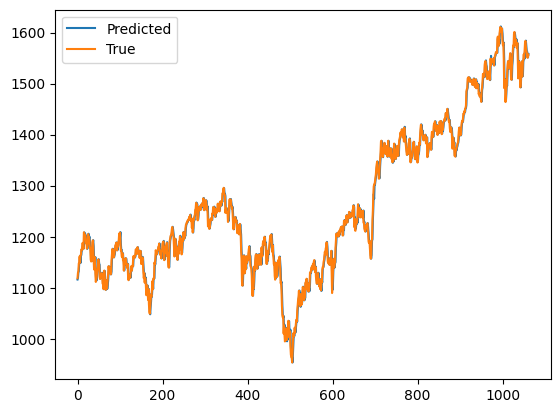

In [46]:
plt.plot(result, label = 'Predicted')
plt.plot(y_groundtruth, label = 'True')
plt.legend()
plt.show()

## RNN

##### RNN

In [47]:
# use the same parameters as above
#
model = 'rnn'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

rnn_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 30 with validation loss: 0.010083571258114606
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 17 with validation loss: 0.010217014200440267
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 11 with validation loss: 0.010365298296120472
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 11 with validation loss: 0.010459338945177634
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 15 with validation loss: 0.010561615893072107
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 11 with validation loss: 0.010619146516546607
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 26 with validation loss: 0.01062684770241925
#-------------------------
Now running model: Hidden-size 15,  lookb

In [48]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  rnn

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 169.943260
MAE: 10.231014
RMSE: 13.036229
MAPE: 12.993012

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 155.946882
MAE: 9.609144
RMSE: 12.487869
MAPE: 0.775451


In [49]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 59.654676
MAE: 6.151066
RMSE: 7.723644
MAPE: 0.497447


In [50]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 29.309871
MAE: 4.270098
RMSE: 5.413859
MAPE: 0.343954


## GRU

In [51]:
# use the same parameters as above
#
model = 'gru'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

gru_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 52 with validation loss: 0.010205810100249037
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 11 with validation loss: 0.010216883065678724
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 14 with validation loss: 0.010236741435464198
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 15 with validation loss: 0.010290469105423587
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 11 with validation loss: 0.010353142372900394
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 11 with validation loss: 0.01040761719071647
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 13 with validation loss: 0.01047725816507165
#-------------------------
Now running model: Hidden-size 15,  lookba

In [52]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  gru

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 170.049824
MAE: 10.108265
RMSE: 13.040315
MAPE: 13.000710

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 155.946882
MAE: 9.609144
RMSE: 12.487869
MAPE: 0.775451


In [53]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 56.472322
MAE: 5.873470
RMSE: 7.514807
MAPE: 0.475019


In [54]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 25.437398
MAE: 3.864708
RMSE: 5.043550
MAPE: 0.311881


## Bi-LSTM

In [55]:
# use the same parameters 
#
model = 'blstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

blstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 45 with validation loss: 0.009994356200189852
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 11 with validation loss: 0.010018714095988288
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 24 with validation loss: 0.010038881301425578
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 20 with validation loss: 0.010039106607664286
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 12 with validation loss: 0.010045747272670269
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 15 with validation loss: 0.01007030682820009
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 11 with validation loss: 0.010079285163977525
#-------------------------
Now running model: Hidden-size 15,  lookb

In [56]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  blstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 158.259059
MAE: 9.753448
RMSE: 12.580106
MAPE: 12.999315

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 155.946882
MAE: 9.609144
RMSE: 12.487869
MAPE: 0.775451


In [57]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 52.840376
MAE: 5.657103
RMSE: 7.269139
MAPE: 0.457782


In [58]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 22.518051
MAE: 3.661804
RMSE: 4.745319
MAPE: 0.295499


## Stacked LSTM

In [59]:
#
model = 'stackedlstm'

best_params, best_historical_losses, best_val_loss, \
                        best_model, historical_losses = grid_search_model(X_mm, y_mm, model, **model_params)

stackedlstm_dict = {
    'best_params': best_params,
    'best_historical_losses': best_historical_losses,
    'best_val_loss': best_val_loss,
    'best_model': best_model,
    'historical_losses': historical_losses,
}

#-------------------------
Now running model: Hidden-size 5,  lookback 1


Early stopping at epoch 56 with validation loss: 0.009954707015578339
#-------------------------
Now running model: Hidden-size 15,  lookback 1
Early stopping at epoch 11 with validation loss: 0.009961565922400573
#-------------------------
Now running model: Hidden-size 30,  lookback 1
Early stopping at epoch 13 with validation loss: 0.009975849968812815
#-------------------------
Now running model: Hidden-size 5,  lookback 5
Early stopping at epoch 12 with validation loss: 0.009989986457384942
#-------------------------
Now running model: Hidden-size 15,  lookback 5
Early stopping at epoch 15 with validation loss: 0.010001446835969279
#-------------------------
Now running model: Hidden-size 30,  lookback 5
Early stopping at epoch 19 with validation loss: 0.010013815163203129
#-------------------------
Now running model: Hidden-size 5,  lookback 10
Early stopping at epoch 11 with validation loss: 0.01001670845307228
#-------------------------
Now running model: Hidden-size 15,  lookb

In [60]:
result, value_y_test, y_groundtruth, _ = create_test_arrays(X_test_tensors_final, df, best_model, mm)

print("NN model is : ", model)
print('\n#-------------------------------')
print('Comparison between the groundtruth and our predictions')
(mse, mae, rmse, mape) = compute_metrics(y_groundtruth, result)
days_1[str(model)] = (mse, mae, rmse, mape)

print('\n#-------------------------------')
print('Comparison between groundtruth and the shifted y_array')
_ = compute_metrics(y_groundtruth, value_y_test)

NN model is :  stackedlstm

#-------------------------------
Comparison between the groundtruth and our predictions
MSE: 156.533323
MAE: 9.648728
RMSE: 12.511328
MAPE: 13.002422

#-------------------------------
Comparison between groundtruth and the shifted y_array
MSE: 155.946882
MAE: 9.609144
RMSE: 12.487869
MAPE: 0.775451


In [61]:
# 3-day analysis 
result, value_y_test, y_groundtruth
N = 3
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_3[str(model)] = (mse, mae, rmse, mape)

MSE: 52.280716
MAE: 5.593246
RMSE: 7.230541
MAPE: 0.452193


In [62]:
# 7-day analysis 
N = 7
ret_N = create_N_day_mean(pd.Series(result), N)
gt_N = create_N_day_mean(pd.Series(y_groundtruth), N)

(mse, mae, rmse, mape) = compute_metrics(ret_N, gt_N)
days_7[str(model)] = (mse, mae, rmse, mape)

MSE: 22.105833
MAE: 3.592443
RMSE: 4.701684
MAPE: 0.290095


# Data aggregation

In [63]:
# DICTS
# days_1 = dict()
# days_3 = dict()
# days_7 = dict()

In [64]:
days1df = pd.DataFrame(days_1, index=['mse', 'mae', 'rmse', 'mape'])
days3df = pd.DataFrame(days_3, index=['mse', 'mae', 'rmse', 'mape'])
days7df = pd.DataFrame(days_7, index=['mse', 'mae', 'rmse', 'mape'])

In [65]:
def highlight_min_and_second_min(s):
    sorted_vals = sorted(s)
    min_val = sorted_vals[0]  # Get the lowest value in each row
    second_min_val = sorted_vals[1]  # Get the second lowest value in each row
    is_min = s == min_val
    is_second_min = s == second_min_val
    styles = ['font-weight: bold' if v else '' for v in is_min]
    for i, v in enumerate(is_second_min):
        if v:
            styles[i] += 'text-decoration: underline'
    return styles

styled_df = days1df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,155.496030,169.943260,170.049824,158.259059,156.533323
mae,9.619382,10.231014,10.108265,9.753448,9.648728
rmse,12.469805,13.036229,13.040315,12.580106,12.511328
mape,13.000086,12.993012,13.000710,12.999315,13.002422


In [66]:
styled_df = days3df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,51.602460,59.654676,56.472322,52.840376,52.280716
mae,5.554603,6.151066,5.873470,5.657103,5.593246
rmse,7.183485,7.723644,7.514807,7.269139,7.230541
mape,0.449406,0.497447,0.475019,0.457782,0.452193


In [67]:
styled_df = days7df.style.apply(highlight_min_and_second_min, axis=1)

# Display styled DataFrame
styled_df

,lstm,rnn,gru,blstm,stackedlstm
mse,22.512582,29.309871,25.437398,22.518051,22.105833
mae,3.606683,4.270098,3.864708,3.661804,3.592443
rmse,4.744743,5.413859,5.043550,4.745319,4.701684
mape,0.291479,0.343954,0.311881,0.295499,0.290095
